In [1]:
import os
from pathlib import Path

if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd().parent.resolve()

os.chdir(PROJECT_ROOT)

In [2]:
from src.dumpy import Dumpy, DumpyJoint
import itertools
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import torch
from torch import Tensor
from torch.nn import Module
import torch.nn.functional as F
from torch.optim import SGD
from tqdm import tqdm

## Load data

> ![NOTE]
> James has kindly sent me the preprocessed and translated data, as well as the trained alphabet.
> I have taken the files he has sent me and saved them in on my local machine inside an ignored directory called "ignore".
> Hence the below lines, but note that they won't run on your machine unless you have copies of the data too.

In [3]:
alphabet = pd.read_csv("ignore/alphabet.csv", index_col=0)
data = pd.read_csv("ignore/translation_train.csv", index_col=0, dtype=str)
olga_marginal = pd.read_csv("ignore/average_olga_vector.csv", header=None).values.squeeze()

olga_marginal = torch.tensor(olga_marginal, dtype=torch.float32)

In [4]:
alphabet

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
Letter,0,1,0,1,0,1,1,0,1,0,0,0,0,1,1,1,0,0,0,1


In [5]:
data.head()

,Unnamed: 0,Studies,Assays,TCR species,CDR3A,CDR3B,TRAV,TRBV,epitope,MHCA,MHCB,MHC class,CDR3B_length,epitope_length,translation_CDR3B,translation_epitope
0,17,10xGenomics,"dextramer-sort,dextramer-sort",HomoSapiens,CAFDRNNAGNMLTF,LGSGGTDTQY,TRAV24*01,TRBV4-3*01,GGALQ,HLA-A*03:01,B2M,1.0,15,9,0111100011,11001
1,18,10xGenomics,"dextramer-sort,dextramer-sort",HomoSapiens,CAFDRNNAGNMLTF,LGSGGTDTQY,TRAV24*01,TRBV4-3*01,GGALQ,HLA-A*03:01,B2M,1.0,15,9,0111100011,11001
2,19,10xGenomics,multimer/tetramer,HomoSapiens,CAMRRPSGGYNKLIF,LASGRSTEAF,NaN,NaN,RAEAQ,HLA-A*03:01,B2M,1.0,15,9,0011110100,10101
3,26,PMID:34793243,tetramer-sort,HomoSapiens,CAVSGWGGNTPLVF,SGTGGQYEQY,TRAV8-1*01,TRBV28*01,FHLYL,HLA-A*01:01,B2M,1.0,15,9,1101111111,01010
4,38,PMID:28636589,multimer/tetramer,HomoSapiens,NaN,QARLYQETQY,NaN,TRBV4-1,CTLVA,HLA-A*02:01,B2M,1.0,15,9,1010111011,10000


In [6]:
olga_marginal

tensor([0.4545, 0.5267, 0.5968, 0.6162, 0.5930, 0.4447, 0.6064, 0.6376, 0.6993,
        0.5556])

In [7]:
def compute_epitope_priors(epi_length: int, num_ones_in_alphabet: int) -> dict:
    """
    Compute the prior probability of each epitope of length `epi_length` given the alphabet.
    """
    prob_one = num_ones_in_alphabet / 20
    prob_zero = 1 - prob_one

    possible_epitopes = [tuple(prod) for prod in itertools.product([0,1], repeat=epi_length)]
    
    def compute_prob(epitope: tuple) -> float:
        return prob_one ** epitope.count(1) * prob_zero ** epitope.count(0)
    
    return {epitope: compute_prob(epitope) for epitope in possible_epitopes}

In [8]:
num_ones_in_alphabet = int(alphabet.loc["Letter"].sum())
epitope_priors = compute_epitope_priors(5, num_ones_in_alphabet)

In [9]:
# Turn translated sequences into torch tensors
def map_zero_one_string_to_tensor(zero_one_string: str) -> Tensor:
    return torch.tensor([float(char) for char in zero_one_string])

tcr_tensor = torch.stack(data["translation_CDR3B"].map(map_zero_one_string_to_tensor).tolist())
epitope_tensor = torch.stack(data["translation_epitope"].map(map_zero_one_string_to_tensor).tolist())

## Train

Here the hyperparameter **lambda** (`lmb` in code) is the relative weighting of the **marginal loss term** (how close the model's marginal TCR distribution is to the target OLGA marginal) compared to the **conditional loss term** (how well the model can predict TCR given epitope).
I execute 10 different training runs with varying lambda, to see which lambda we like the trade-off of most.
This trade-off is evaluated later down in the notebook.

In [10]:
def train(epitope_tensor: Tensor, tcr_tensor: Tensor, epitope_priors: dict[tuple, float], target_marginal: Tensor, lmb: float, epochs: int = 5000):
    model = Dumpy(5, 10)
    optimizer = SGD(model.parameters(), lr=1)

    losses = []

    for _ in tqdm(range(epochs)):
        optimizer.zero_grad()

        model_output = model.forward_logit(epitope_tensor)
        model_marginal = compute_model_marginal(model, epitope_priors)
        conditional_loss = F.binary_cross_entropy_with_logits(model_output, tcr_tensor)
        marginal_loss = F.binary_cross_entropy(model_marginal, target_marginal.unsqueeze(0))
        loss = conditional_loss + lmb * marginal_loss

        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f"Lambda: {lmb}")
    print(f"Conditional loss: {conditional_loss.item()}")
    print(f"Marginal loss: {marginal_loss.item()}")

    plt.figure(figsize=(3,1))
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return model, conditional_loss.item(), marginal_loss.item()

def compute_model_marginal(model: Module, epitope_priors: dict[tuple, float]) -> Tensor:
    weighted_conditionals = [model.forward(torch.tensor(epitope, dtype=torch.float32).unsqueeze(0)) * epitope_prior for epitope, epitope_prior in epitope_priors.items()]
    return torch.sum(torch.stack(weighted_conditionals, dim=0), dim=0)

def compute_average_data_likelihood(model: Module, epitope_tensor: Tensor, tcr_tensor: Tensor) -> float:
    model_output = model.forward_logit(epitope_tensor)
    return F.binary_cross_entropy_with_logits(model_output, tcr_tensor).item()

100%|██████████| 5000/5000 [00:09<00:00, 533.78it/s]

Lambda: 0.10000000149011612
Conditional loss: 0.6601527333259583
Marginal loss: 0.6738894581794739


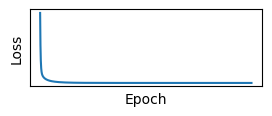

100%|██████████| 5000/5000 [00:09<00:00, 552.61it/s]

Lambda: 0.1668100506067276
Conditional loss: 0.6602380275726318
Marginal loss: 0.6732409596443176


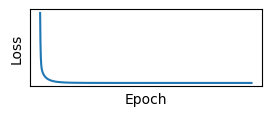

100%|██████████| 5000/5000 [00:09<00:00, 529.62it/s]


Lambda: 0.2782559394836426
Conditional loss: 0.6603929400444031
Marginal loss: 0.672529935836792


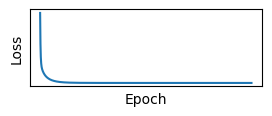

100%|██████████| 5000/5000 [00:09<00:00, 526.71it/s]

Lambda: 0.46415889263153076
Conditional loss: 0.6606302261352539
Marginal loss: 0.6718717217445374


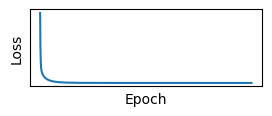

100%|██████████| 5000/5000 [00:10<00:00, 494.93it/s]

Lambda: 0.7742636799812317
Conditional loss: 0.6609320640563965
Marginal loss: 0.6713659167289734


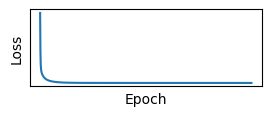

100%|██████████| 5000/5000 [00:09<00:00, 553.03it/s]

Lambda: 1.2915496826171875
Conditional loss: 0.6612515449523926
Marginal loss: 0.6710426211357117


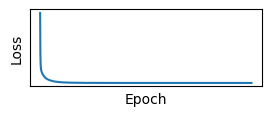

100%|██████████| 5000/5000 [00:09<00:00, 509.00it/s]

Lambda: 2.1544346809387207
Conditional loss: 0.6615395545959473
Marginal loss: 0.6708666682243347


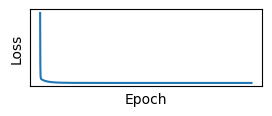

100%|██████████| 5000/5000 [00:10<00:00, 487.01it/s]

Lambda: 3.59381365776062
Conditional loss: 0.6617679595947266
Marginal loss: 0.6707828044891357


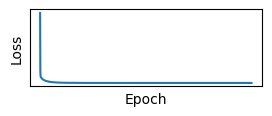

100%|██████████| 5000/5000 [00:09<00:00, 524.71it/s]

Lambda: 5.994842529296875
Conditional loss: 0.6619325280189514
Marginal loss: 0.6707464456558228


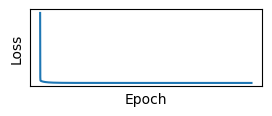

100%|██████████| 5000/5000 [00:10<00:00, 480.62it/s]

Lambda: 10.0
Conditional loss: 0.6620433926582336
Marginal loss: 0.6707316040992737


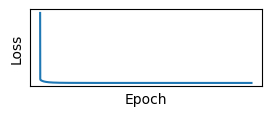

In [11]:
lmbs = torch.logspace(-1, 1, 10)
results = {lmb.item(): train(epitope_tensor, tcr_tensor, epitope_priors, olga_marginal, lmb) for lmb in lmbs}

## Inspect different pareto-optimal models

In [12]:
conditional_losses = [result[1] for result in results.values()]
marginal_losses = [result[2] for result in results.values()]
results_table = pd.DataFrame({"Lambda": results.keys(), "Conditional loss": conditional_losses, "Marginal loss": marginal_losses})

In [13]:
results_table

,Lambda,Conditional loss,Marginal loss
0,0.100000,0.660153,0.673889
1,0.166810,0.660238,0.673241
2,0.278256,0.660393,0.672530
3,0.464159,0.660630,0.671872
4,0.774264,0.660932,0.671366
5,1.291550,0.661252,0.671043
6,2.154435,0.661540,0.670867
7,3.593814,0.661768,0.670783
8,5.994843,0.661933,0.670746
9,10.000000,0.662043,0.670732


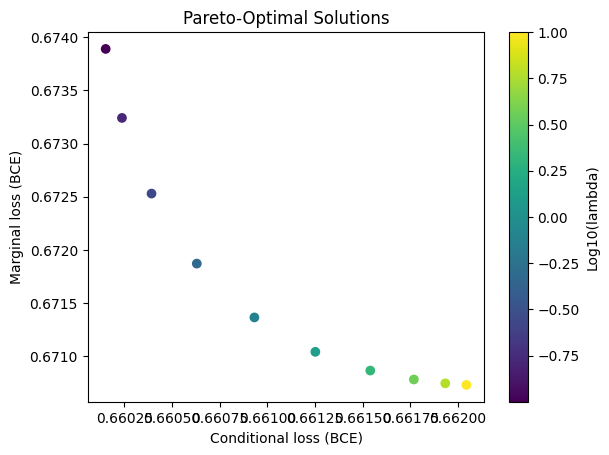

In [14]:
plt.figure()

scatter = plt.scatter(results_table["Conditional loss"], results_table["Marginal loss"], c=np.log10(results_table["Lambda"]))
plt.colorbar(scatter, label="Log10(lambda)")

plt.title("Pareto-Optimal Solutions")
plt.xlabel("Conditional loss (BCE)")
plt.ylabel("Marginal loss (BCE)")

plt.show()

In [76]:
lambda_of_choice = results_table["Lambda"].iloc[4]

## Save favourite model

In [77]:
dumpy_of_choice = results[lambda_of_choice][0]
torch.save(dumpy_of_choice.state_dict(), "model_saves/dumpy_of_choice.pth")

## Make joint model

The `Dumpy` model on its own can only compute the conditional distribution of TCRs given epitope.
A combination of a Dumpy instance and a prior distribution over the epitope hypercube gives you the full joint distribution.
I implement a class below which concretises this idea.

In [78]:
joint_model = DumpyJoint(dumpy_of_choice, epitope_priors)
mini_tcr_tensor = tcr_tensor[:5]
mini_epitope_tensor = epitope_tensor[:5]

In [79]:
joint_model.joint(mini_tcr_tensor, mini_epitope_tensor)

tensor([[5.4921e-05, 5.4921e-05, 4.8010e-05, 8.0630e-05, 5.9778e-05],
        [5.4921e-05, 5.4921e-05, 4.8010e-05, 8.0630e-05, 5.9778e-05],
        [3.4248e-05, 3.4248e-05, 1.7440e-05, 4.1204e-05, 2.9215e-05],
        [4.5946e-05, 4.5946e-05, 8.6016e-05, 4.9223e-05, 7.4652e-05],
        [1.4539e-05, 1.4539e-05, 3.4581e-05, 2.2557e-05, 2.9548e-05]])

In [80]:
all_possible_tcrs = torch.stack([torch.tensor(prod, dtype=torch.float32) for prod in itertools.product([0,1], repeat=10)])
all_possible_epitopes = torch.stack([torch.tensor(epitope, dtype=torch.float32) for epitope in epitope_priors.keys()])
joint_model.joint(all_possible_tcrs, all_possible_epitopes).sum() # Should be 1, sanity check

tensor(1.0000)

## AUCs

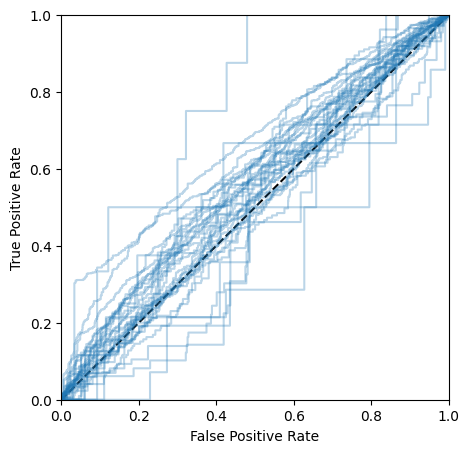

In [81]:
unique_epitopes = data["translation_epitope"].unique()
all_epitopes = epitope_tensor.unique(dim=0)

plt.figure(figsize=(5,5))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1], [0,1], linestyle="--", c="black")

for epitope in unique_epitopes:
    positive_indices = (data["translation_epitope"] == epitope).to_numpy()
    negative_indices = ~positive_indices

    positive_tcrs = tcr_tensor[positive_indices]
    negative_tcrs = tcr_tensor[negative_indices]
    target_epitope = epitope_tensor[positive_indices][:1]

    p_target_ep_positives = joint_model.joint(positive_tcrs, target_epitope).squeeze()
    p_all_eps_positives = joint_model.joint(positive_tcrs, all_epitopes).sum(dim=1)
    p_target_ep_positives_normalized = p_target_ep_positives / p_all_eps_positives # Relative prob of target epitope out of all possible

    p_target_ep_negatives = joint_model.joint(negative_tcrs, target_epitope).squeeze()
    p_all_eps_negatives = joint_model.joint(negative_tcrs, all_epitopes).sum(dim=1)
    p_target_ep_negatives_normalized = p_target_ep_negatives / p_all_eps_negatives # Same as above, but for negative TCRs

    all_positive_probs = torch.concatenate((p_target_ep_positives_normalized, p_target_ep_negatives_normalized))
    all_labels = torch.concatenate((torch.ones_like(p_target_ep_positives_normalized), torch.zeros_like(p_target_ep_negatives_normalized)))

    fprs, tprs, _ = metrics.roc_curve(all_labels, all_positive_probs)
    plt.step(fprs, tprs, c="C0", alpha=0.3)

plt.show()